In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import tensorflow as tf
from tensorflow import keras

house_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
train_labels = house_data["SalePrice"]
train_data = house_data
train_data.drop(columns="SalePrice")




,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal


Columns contain mixture of categorical data and numerical data, these will require different preprocessing. We have:
* Numerical data: This needs to be scaled between 0 and 1.
* Categorical data (including the zoning code!): This needs to be one-hot encoded.
* 'Quality' categories: This needs to be converted to an equal numeric range between 0 and 1.

Missing values must also be managed:
* For numerical columns, exclude all NA rows to find the mean, then replace NA with the mean wherever it appears
* For categorical columns, NA will be included as a category
* Neither the training data nor test data contains any nulls (but if they were there then they should be replaced with NA first, then subjected to the same processing.

All these steps must be performed on the training data and validation data separately after splitting them! (wrap in function to take each) otherwise replacement with the mean of the whole dataset would lead to information leakage between train and validation sets.

In [3]:
def quality_preprocess(data):
    lotshapeencode = {"Reg":0, "IR1":1, "IR2":2, "IR3":3}
    data["LotShape"] = data["LotShape"].replace(lotshapeencode)
    landslopeencode = {"Gtl":0, "Mod":1, "Sev":2}
    data["LandSlope"] = data["LandSlope"].replace(landslopeencode)
    qualcondencode = {"Ex":0, "Gd":1, "TA":2, "Fa":3, "Po":4}
    data["ExterQual"] = data["ExterQual"].replace(qualcondencode)
    data["ExterCond"] = data["ExterCond"].replace(qualcondencode)
    data["BsmtQual"] = data["BsmtQual"].replace(qualcondencode)
    data["BsmtCond"] = data["BsmtCond"].replace(qualcondencode)
    exposureencode = {"Gd":0, "Av":1, "Mn":2, "No":3}
    data["BsmtExposure"] = data["BsmtExposure"].replace(exposureencode)
    data["HeatingQC"] = data["HeatingQC"].replace(qualcondencode)
    data["KitchenQual"] = data["KitchenQual"].replace(qualcondencode)
    functionalencode = {"Typ":0, "Min1":1, "Min2":2, "Mod":3, "Maj1":4, "Maj2":5, "Sev":6, "Sal":7}
    data["Functional"] = data["Functional"].replace(functionalencode)
    data["FireplaceQu"] = data["FireplaceQu"].replace(qualcondencode)
    finishencode = {"Fin":0, "RFn":1, "Unf":2}
    data["GarageFinish"] = data["GarageFinish"].replace(finishencode)
    data["GarageQual"] = data["GarageQual"].replace(qualcondencode)
    data["GarageCond"] = data["GarageCond"].replace(qualcondencode)
    data["PoolQC"] = data["PoolQC"].replace(qualcondencode)
    fenceencode = {"GdPrv":0, "MnPrv":1, "GdWo":2, "MnWw":3, "NA":4}
    data["Fence"] = data["Fence"].replace(fenceencode)
    return data


Define which columns should be categorical, and which should be numerical

In [4]:
categorical_features = [
    "MSSubClass",
    "MSZoning",
    "Street",
    "Alley",
    "LandContour",
    "Utilities",
    "LotConfig",
    "Neighborhood",
    "Condition1",
    "Condition2",
    "BldgType",
    "HouseStyle",
    "RoofStyle",
    "RoofMatl",
    "Exterior1st",
    "Exterior2nd",
    "MasVnrType",
    "Foundation",
    "BsmtFinType1",
    "BsmtFinType2",
    "Heating",
    "CentralAir",
    "Electrical",
    "GarageType",
    "PavedDrive",
    "MiscFeature",
    "SaleType",
    "SaleCondition"
]

numerical_features = [
    "LotFrontage",
    "LotArea",
    "LotShape",
    "LandSlope",
    "OverallQual",
    "OverallCond",
    "YearBuilt",
    "YearRemodAdd",
    "MasVnrArea",
    "ExterQual",
    "ExterCond",
    "BsmtQual",
    "BsmtCond",
    "BsmtExposure",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "BsmtUnfSF",
    "TotalBsmtSF",
    "HeatingQC",
    "1stFlrSF",
    "2ndFlrSF",
    "LowQualFinSF",
    "GrLivArea",
    "BsmtFullBath",
    "BsmtHalfBath",
    "FullBath",
    "HalfBath",
    "BedroomAbvGr",
    "KitchenAbvGr",
    "KitchenQual",
    "TotRmsAbvGrd",
    "Functional",
    "Fireplaces",
    "FireplaceQu",
    "GarageYrBlt",
    "GarageFinish",
    "GarageCars",
    "GarageArea",
    "GarageQual",
    "GarageCond",
    "WoodDeckSF",
    "OpenPorchSF",
    "EnclosedPorch",
    "3SsnPorch",
    "ScreenPorch",
    "PoolArea",
    "PoolQC",
    "Fence",
    "MiscVal",
    "MoSold",
    "YrSold"
]

assert len(categorical_features) + len(numerical_features) == 79

Write preprocess instructions for categorical features, and loop for numerical features

In [5]:
def one_hot_feature(data, feature, featlist):
    one_hot = pd.get_dummies(data[feature])
    for feat in featlist:
        if feat not in one_hot.keys():
            one_hot[feat] = 0
    newnames = []
    for feat in featlist:
        newname = feature + '.' + feat
        newnames.append(newname)
    rename_dict = dict(zip(featlist, newnames))
    one_hot = one_hot.rename(columns = rename_dict)
    data = data.drop(columns = feature)
    data = data.join(one_hot)
    return data

def categorical_preprocess(data):
    subclasslist = ["20","30","40","45","50","60","70","75","80","85","90","120","150","160","180","190"]
    data = one_hot_feature(data, "MSSubClass", subclasslist)
    zoninglist = ['A', 'C (all)','FV','I','RH','RL','RP','RM']
    data = one_hot_feature(data, "MSZoning", zoninglist)
    streetlist = ['Grvl','Pave']
    data = one_hot_feature(data, "Street", streetlist)
    alleylist = ['Grvl','Pave','NA']
    data = one_hot_feature(data, "Alley", alleylist)
    contourlist = ['Lvl','Bnk','HLS','Low']
    data = one_hot_feature(data, "LandContour", contourlist)
    utilitieslist = ['AllPub', 'NoSewr', 'NoSeWa', 'ELO']
    data = one_hot_feature(data, "Utilities", utilitieslist)
    lotconfiglist = ['Inside','Corner','CulDSac','FR2','FR3']
    data = one_hot_feature(data, "LotConfig", lotconfiglist)
    neighborhoodlist = [
        'Blmngtn',
        'Blueste',
        'BrDale',
        'BrkSide',
        'ClearCr',
        'CollgCr',
        'Crawfor',
        'Edwards',
        'Gilbert',
        'IDOTRR',
        'MeadowV',
        'Mitchel',
        'Names',
        'NoRidge',
        'NPkVill',
        'NridgHt',
        'NWAmes',
        'OldTown',
        'SWISU',
        'Sawyer',
        'SawyerW',
        'Somerst',
        'StoneBr',
        'Timber',
        'Veenker'
    ]
    data = one_hot_feature(data, "Neighborhood", neighborhoodlist)
    conditionlist = ['Artery','Feedr','Norm','RRNn','RRAn','PosN','PosA','RRNe','RRAe']
    data = one_hot_feature(data, "Condition1", conditionlist)
    data = one_hot_feature(data, "Condition2", conditionlist)
    bldgtypelist = ['1Fam','2FmCon','Duplx','TwnhsE','TwnhsI']
    data = one_hot_feature(data, "BldgType", bldgtypelist)
    housestylelist = ['1Story','1.5Fin','1.5Unf','2Story','2.5Fin','2.5Unf','SFoyer','SLvl']
    data = one_hot_feature(data, "HouseStyle", housestylelist)
    roofstylelist = ['Flat','Gable','Gambrel','Hip','Mansard','Shed']
    data = one_hot_feature(data, "RoofStyle", roofstylelist)
    roofmatllist = ['ClyTile','CompShg','Membran','Metal','Roll','Tar&Grv','WdShake','WdShngl']
    data = one_hot_feature(data, "RoofMatl", roofmatllist)
    exteriorlist = [
        'AsbShng',
        'AsphShn',
        'BrkFace',
        'BrkComm',
        'CBlock',
        'CemntBd',
        'HdBoard',
        'ImStucc',
        'MetalSd',
        'Other',
        'Plywood',
        'PreCast',
        'Stone',
        'Stucco',
        'VinylSd',
        'Wd Sdng',
        'WdShing'
    ]
    data = one_hot_feature(data, "Exterior1st", exteriorlist)
    data = one_hot_feature(data, "Exterior2nd", exteriorlist)
    masvnrtypelist = ['BrkCmn','BrkFace','CBlock','None','Stone']
    data = one_hot_feature(data, "MasVnrType", masvnrtypelist)
    foundationlist = ["BrkTil",'Cblock','PConc','Slab','Stone','Wood']
    data = one_hot_feature(data, "Foundation", foundationlist)
    bsmtfinlist = ['GLQ','ALQ','BLQ','Rec','LwQ','Unf','NA']
    data = one_hot_feature(data, "BsmtFinType1", bsmtfinlist)
    data = one_hot_feature(data, "BsmtFinType2", bsmtfinlist)
    heatinglist = ['Floor','GasA','GasW','Grav','OthW','Wall']
    data = one_hot_feature(data, "Heating", heatinglist)
    centralairlist = ['N','Y']
    data = one_hot_feature(data, "CentralAir", centralairlist)
    electricallist = ['SBrkr','FuseA','FuseF','FuseP','Mix']
    data = one_hot_feature(data, "Electrical", electricallist)
    garagelist = ['2Types','Attchd','Basement','BuiltIn','CarPort','Detchd','NA']
    data = one_hot_feature(data, "GarageType", garagelist)
    paveddrivelist = ['Y','N','P']
    data = one_hot_feature(data, "PavedDrive", paveddrivelist)
    misclist = ['Elev','Gar2','Othr','Shed','TenC','NA']
    data = one_hot_feature(data, "MiscFeature", misclist)
    saletypelist = ['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth']
    data = one_hot_feature(data, "SaleType", saletypelist)
    saleconditionlist = ['Normal','Abnorml','AdjLand','Alloca','Family','Partial']
    data = one_hot_feature(data, "SaleCondition", saleconditionlist)
    return data

def numerical_preprocess(data):
    for feature in numerical_features:
        data[feature] = data[feature].replace({"NA":pd.NA})
        mean = data[feature].mean()
        data[feature] = data[feature].fillna(mean)
        stddev = data[feature].std(ddof=0)
        data[feature] = data[feature].sub(mean)
        data[feature] = data[feature].div(stddev)
    return data

def full_preprocess(data):
    data = quality_preprocess(data)
    data = categorical_preprocess(data)
    data = numerical_preprocess(data)
    data = data.drop(columns = "Id")
    data = data.astype("float64")
    return data


Prepare the model

In [6]:
LEARNING_RATE = 0.001

def build_model():
    model = keras.Sequential([
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(16, activation='relu'),
        keras.layers.Dense(1)
    ])
    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])
    return model


Set aside validation set and run the model. Initially will start with basic validation, will implement k-fold later

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Epoch 1/30
3/3 [==============================] - 1s 111ms/step - loss: 37271453696.0000 - mae: 176577.0625 - val_loss: 39074717696.0000 - val_mae: 182226.6875
Epoch 2/30
3/3 [==============================] - 0s 21ms/step - loss: 36390404096.0000 - mae: 174477.0781 - val_loss: 39074717696.0000 - val_mae: 182226.6719
Epoch 3/30
3/3 [==============================] - 0s 36ms/step - loss: 35511406592.0000 - mae: 172357.3906 - val_loss: 39074713600.0000 - val_mae: 182226.6719
Epoch 4/30
3/3 [==============================] - 0s 20ms/step - loss: 34640445440.0000 - mae: 170219.6875 - val_loss: 39074713600.0000 - val_mae: 182226.6719
Epoch 5/30
3/3 [==============================] - 0s 18ms/step - loss: 33765062656.0000 - mae: 168049.3906 - val_loss: 39074709504.0000 - val_mae: 182226.6562
Epoch 6/30
3/3 [==============================] - 0s 18ms/step - loss: 32867414016.0000 - mae: 165809.3281 - val_loss: 39074709504.0000 - val_mae: 182226.6562
Epoch 7/30
3/3 [=============================

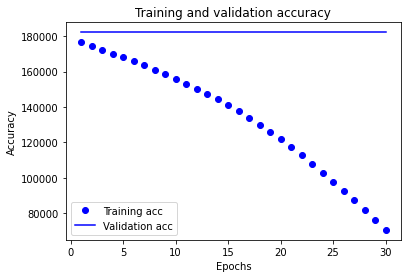

In [7]:
val_data = train_data.iloc[1:200]
val_labels = train_labels.iloc[1:200]
partial_train_data = train_data.iloc[200:train_data["Id"].size]
partial_train_labels = train_labels.iloc[200:train_labels.size]
val_data = full_preprocess(val_data)
partial_train_data = full_preprocess(partial_train_data)

EPOCHS = 30

model = build_model()

history = model.fit(partial_train_data,
                    partial_train_labels,
                    epochs=EPOCHS,
                    batch_size=512,
                    validation_data=(val_data, val_labels),
                    verbose=1,
                    )

history_dict = history.history
print(history_dict)

acc = history_dict['mae']
val_acc = history_dict['val_mae']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()